In [1]:
!pip install torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 111.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 117.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [6]:
!pip install keras


In [14]:
# 1. Gerekli Kütüphaneleri Yükle
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt


In [15]:
from google.colab import files
uploaded = files.upload()

# Yüklediğin dosyanın adını buraya yaz
df = pd.read_csv("/content/cleaned_reviews_5000 (1).csv")

# Yalnızca yorum metni ve etiket
df = df[["translated_text", "label"]].dropna()


Saving cleaned_reviews_5000 (1).csv to cleaned_reviews_5000 (1) (2).csv


In [22]:
df

,translated_text,label
0,Diğer tüm çeşme filtrelerimi değiştirdim ve re...,0
1,LT&T hayal kırıklığına uğratmadı. Bu kitapta ...,0
2,Her iki köpeklerim de (tam yetişkin) tadı sevi...,0
3,"İlk kez kullanıcı, geçen sefer yapıştırın. 4 y...",0
4,Klein hiçbiri ikinci değil. Klein ürünlerinin...,0
...,...,...
4995,Bunlar harika. Torunumuz onları burada olduğu...,1
4996,mükemmel çalışıyor. Aralık ve hassasiyet bekle...,1
4997,"Bunlar torunumdu, 7 yaşında ve onlara sahip ol...",1
4998,MacBook Pro'm ısınıyor. Bir soğutma fanı ile ç...,1


In [16]:
X = df["translated_text"].values
y = df["label"].values

# Train/Test böl
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF ile vektörleştirme
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()


In [17]:
class ReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = ReviewDataset(X_train_tfidf, y_train)
test_dataset = ReviewDataset(X_test_tfidf, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [18]:
class RNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNClassifier, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)  # [batch_size, seq_len=1, input_dim]
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # son zaman adımı
        return self.fc(out)


In [19]:
input_dim = X_train_tfidf.shape[1]
model = RNNClassifier(input_dim=input_dim, hidden_dim=64, output_dim=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 75.5567
Epoch 2, Loss: 47.5903
Epoch 3, Loss: 37.0738
Epoch 4, Loss: 32.6157
Epoch 5, Loss: 29.8084
Epoch 6, Loss: 27.7671
Epoch 7, Loss: 26.5539
Epoch 8, Loss: 25.5936
Epoch 9, Loss: 24.3306
Epoch 10, Loss: 23.6402


In [20]:
model.eval()
preds = []
true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        pred_labels = torch.argmax(outputs, dim=1).cpu().numpy()
        preds.extend(pred_labels)
        true.extend(y_batch.numpy())

print("\n📊 Sınıflandırma Raporu (RNN):")
print(classification_report(true, preds, target_names=["SAHTE", "GERÇEK"]))



📊 Sınıflandırma Raporu (RNN):
              precision    recall  f1-score   support

       SAHTE       0.82      0.79      0.80       500
      GERÇEK       0.80      0.82      0.81       500

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.81      0.81      0.81      1000



<Figure size 600x400 with 0 Axes>

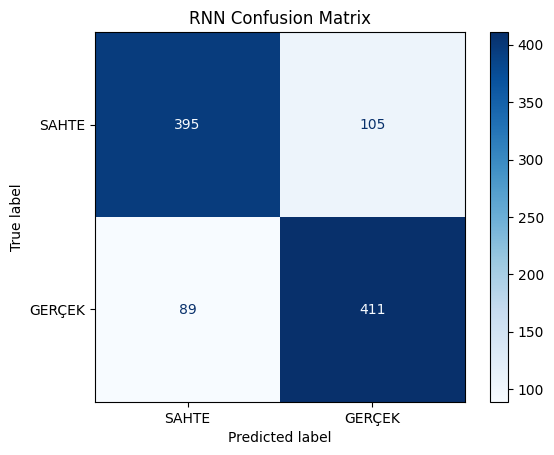

In [21]:
cm = confusion_matrix(true, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["SAHTE", "GERÇEK"])

plt.figure(figsize=(6, 4))
disp.plot(cmap=plt.cm.Blues)
plt.title("RNN Confusion Matrix")
plt.show()
